In [12]:
import pandas as pd

import numpy as np

import os

import geopandas
from shapely.geometry import Point

import re

import datetime as dt

import time

import matplotlib.pyplot as plt
import matplotlib.animation as ani
import matplotlib.font_manager as font_manager
import seaborn as sns

from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from pyspark.sql import SparkSession

import ast

path = os.path.dirname(os.getcwd())

dr_path = path + r"/rest_dr"
dc_path = path + r"/rest_dc"

print(dr_path)



c:\Users\sstei\OneDrive\steiner_research\restaurants_project/rest_dr


## Import census tract data

In [13]:
tn_tract = geopandas.read_file(dr_path + r"/tl_2024_47_tract/tl_2024_47_tract.shp")

tn_tract.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,GEOIDFQ,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,47,073,050501,47073050501,1400000US47073050501,505.01,Census Tract 505.01,G5020,S,83355996,0,+36.5659159,-082.7715246,"POLYGON ((-82.85011 36.54107, -82.84955 36.541..."
1,47,073,050601,47073050601,1400000US47073050601,506.01,Census Tract 506.01,G5020,S,23847669,177932,+36.5836443,-082.6318663,"POLYGON ((-82.68939 36.58793, -82.68936 36.588..."
2,47,073,050602,47073050602,1400000US47073050602,506.02,Census Tract 506.02,G5020,S,23386547,668716,+36.5467218,-082.6458382,"POLYGON ((-82.69446 36.54856, -82.69445 36.548..."
3,47,073,050502,47073050502,1400000US47073050502,505.02,Census Tract 505.02,G5020,S,32873931,311980,+36.5332207,-082.7586081,"POLYGON ((-82.82242 36.52006, -82.82171 36.520..."
4,47,073,050503,47073050503,1400000US47073050503,505.03,Census Tract 505.03,G5020,S,17050728,568444,+36.5225397,-082.6970280,"POLYGON ((-82.73162 36.52804, -82.73108 36.528..."


In [14]:
davidson_tracts = geopandas.GeoDataFrame(tn_tract[tn_tract['COUNTYFP']=='037'][['GEOID', 'geometry']].reset_index(drop=True))

davidson_tracts = davidson_tracts.rename(columns={'GEOID':'tract_id'}).to_crs('epsg:4326')

davidson_tracts.head()

,tract_id,geometry
0,47037010103,"POLYGON ((-86.91752 36.33976, -86.91747 36.339..."
1,47037010202,"POLYGON ((-86.82483 36.33225, -86.82480 36.332..."
2,47037010104,"POLYGON ((-86.97440 36.24991, -86.97244 36.252..."
3,47037010106,"POLYGON ((-86.83089 36.26570, -86.83016 36.265..."
4,47037010602,"POLYGON ((-86.69530 36.25263, -86.69513 36.253..."


## Import clean Nashville restaurant database

In [15]:
nash_database = pd.read_csv(dc_path + r"/nashrestaurants_clean.csv")

# nash_database['stars'] = np.round(nash_database['stars'], 0)

nash_database.head()

,tract_id,business_id,name,address,city,state,postal_code,latitude,longitude,stars,...,kmeans_0_prop,kmeans_1_prop,kmeans_2_prop,kmeans_3_prop,kmeans_4_prop,kmeans_5_prop,kmeans_6_prop,kmeans_7_prop,kmeans_8_prop,kmeans_9_prop
0,47037010106,piPnsKY7GE-B5KVQs8ubsA,Café Fontanella,4125 Whites Creek Pike,Nashville,TN,37189.0,36.257214,-86.829532,3.0,...,0.251969,0.212598,0.000000,0.000000,0.322835,0.000000,0.023622,0.078740,0.007874,0.102362
1,47037019200,d4ZPdoYxDnT6f70AZPGrcw,Sky Blue Cafe,700 Fatherland St,Nashville,TN,37206.0,36.171418,-86.758903,4.0,...,0.175439,0.133333,0.000000,0.011696,0.308772,0.212865,0.065497,0.084211,0.007018,0.001170
2,47037019200,zJmp_J8SUNosLxk6borpFg,The Wild Cow,"1100 Fatherland St, Ste 104",Nashville,TN,37206.0,36.173823,-86.750055,4.5,...,0.050098,0.196464,0.000000,0.038310,0.505894,0.001965,0.103143,0.102161,0.001965,0.000000
3,47037019200,vSvbdFKfr6u5-zykn49CWA,Maru Sushi & Grill - East Nashville,"1100 Fatherland St, Ste 101",Nashville,TN,37206.0,36.173913,-86.750084,4.5,...,0.067416,0.230337,0.000000,0.000000,0.471910,0.000000,0.134831,0.089888,0.005618,0.000000
4,47037019200,vWmh3kJuehx3tDp6rrtqgA,Local Taco,"1100 Fatherland St, Ste 104",Nashville,TN,37206.0,36.173936,-86.750126,3.5,...,0.132530,0.349398,0.012048,0.000000,0.349398,0.000000,0.030120,0.084337,0.042169,0.000000


In [16]:
nash_database2 = nash_database.drop([col for col in nash_database.columns if ('kmeans' in col) & ('prop' not in col)], axis=1)

nash_database2.head()

,tract_id,business_id,name,address,city,state,postal_code,latitude,longitude,stars,...,kmeans_0_prop,kmeans_1_prop,kmeans_2_prop,kmeans_3_prop,kmeans_4_prop,kmeans_5_prop,kmeans_6_prop,kmeans_7_prop,kmeans_8_prop,kmeans_9_prop
0,47037010106,piPnsKY7GE-B5KVQs8ubsA,Café Fontanella,4125 Whites Creek Pike,Nashville,TN,37189.0,36.257214,-86.829532,3.0,...,0.251969,0.212598,0.000000,0.000000,0.322835,0.000000,0.023622,0.078740,0.007874,0.102362
1,47037019200,d4ZPdoYxDnT6f70AZPGrcw,Sky Blue Cafe,700 Fatherland St,Nashville,TN,37206.0,36.171418,-86.758903,4.0,...,0.175439,0.133333,0.000000,0.011696,0.308772,0.212865,0.065497,0.084211,0.007018,0.001170
2,47037019200,zJmp_J8SUNosLxk6borpFg,The Wild Cow,"1100 Fatherland St, Ste 104",Nashville,TN,37206.0,36.173823,-86.750055,4.5,...,0.050098,0.196464,0.000000,0.038310,0.505894,0.001965,0.103143,0.102161,0.001965,0.000000
3,47037019200,vSvbdFKfr6u5-zykn49CWA,Maru Sushi & Grill - East Nashville,"1100 Fatherland St, Ste 101",Nashville,TN,37206.0,36.173913,-86.750084,4.5,...,0.067416,0.230337,0.000000,0.000000,0.471910,0.000000,0.134831,0.089888,0.005618,0.000000
4,47037019200,vWmh3kJuehx3tDp6rrtqgA,Local Taco,"1100 Fatherland St, Ste 104",Nashville,TN,37206.0,36.173936,-86.750126,3.5,...,0.132530,0.349398,0.012048,0.000000,0.349398,0.000000,0.030120,0.084337,0.042169,0.000000


## Create Random Forest model
Use to identify important factors in improving restaurant performance

In [17]:
X = nash_database2.iloc[:, 15:].drop(['geometry', 'cool', 'funny', 'useful', 'ln_reviewct'], axis=1)

y = nash_database2['stars'].astype(str) #.astype(int)

In [18]:
franchise_model = RandomForestRegressor(max_depth = 10, random_state = 42, oob_score=True)

franchise_model.fit(X, y)

print("Franchise model OOB Score: ", franchise_model.oob_score_)

Franchise model OOB Score:  0.670049330395958


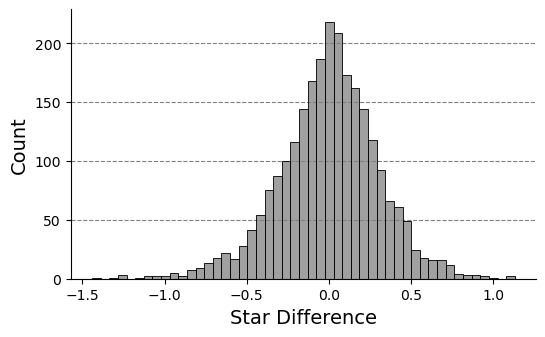

In [19]:
predictions = pd.Series(franchise_model.predict(X))

comparison = nash_database[['business_id', 'tract_id', 'stars']]

comparison = pd.concat([comparison, predictions], axis=1).rename(columns={0:'stars_pred'})

comparison[['stars', 'stars_pred']] = comparison[['stars', 'stars_pred']].astype(float)
comparison['diff'] = comparison['stars'] - comparison['stars_pred']

error = comparison[['business_id', 'diff']].groupby(['diff'], as_index=False).nunique().rename(columns={'business_id':'rest_ct'})

fig, ax = plt.subplots(figsize=(6, 3.5))

sns.histplot(error['diff'], ax=ax, color='gray', edgecolor='black')

ax.set_axisbelow(True)
ax.grid(axis='y', linestyle='--', color='black', alpha=0.5)

ax.set_ylabel('Count', fontsize=14)
ax.set_xlabel('Star Difference', fontsize=14)

sns.despine()

plt.show()

## Identify key factors for increasing average restaurant star rating

In [20]:
start_time = time.time()
importances = franchise_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in franchise_model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.022 seconds


In [37]:
forest_importances = pd.DataFrame(pd.Series(importances, index=X.columns)).reset_index()

forest_importances.columns = ['feature', 'importance']

forest_importances['std'] = std

forest_importances = forest_importances.sort_values(['importance']).tail(20).reset_index(drop=True)

forest_importances.tail()

,feature,importance,std
15,kmeans_4_prop,0.025546,0.008001
16,kmeans_1_prop,0.033268,0.009292
17,kmeans_7_prop,0.073081,0.026330
18,kmeans_6_prop,0.118683,0.019812
19,kmeans_0_prop,0.581605,0.027318


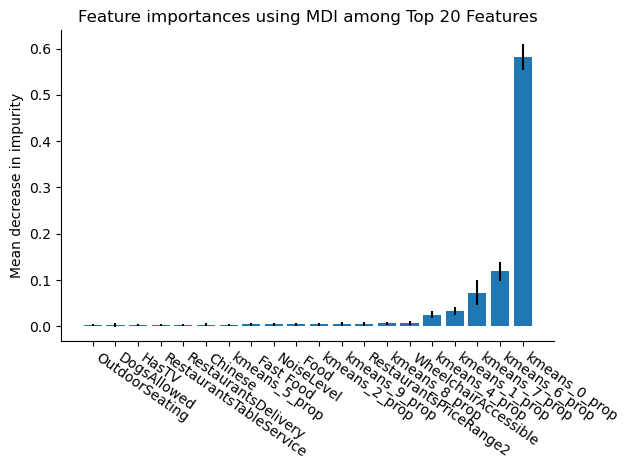

In [41]:
fig, ax = plt.subplots()
ax.bar(forest_importances['feature'], forest_importances['importance'], yerr=forest_importances['std'])
ax.set_title("Feature importances using MDI among Top 20 Features")
ax.set_ylabel("Mean decrease in impurity")

plt.xticks(rotation=-35, ha='left')

sns.despine()

plt.tight_layout()

plt.show()